# NLP Disaster Tweets Project

This project is part of a [Kaggle comptetion](https://www.kaggle.com/competitions/nlp-getting-started) focused on predicting whether tweets contains real disaster.

## Problem Description

Our objective is to address a Natural Language Processing (NLP) task: predicting whether a tweet refers to a real disaster.

The main challenge lies in the ambiguity of language—tweets may contain disaster-related terms without actually describing real events. To tackle this, we use DistilBERT, a pre-trained deep learning model capable of understanding the contextual meaning of text.

We begin by preprocessing the tweets, which includes converting text to lowercase, tokenization, removing stop words, and applying stemming. After preprocessing, we train and make predictions using the DistilBERT model.

To evaluate the model’s performance, we use a confusion matrix, and the final predictions are submitted to the competition platform. We hope this summary clarifies our approach to the problem and the solution we implemented.

### Dataset Description

The dataset consists of tweets labeled as either describing a real disaster (1) or not (0). It is divided into a training set and a test set:

- **Training Set**: Contains tweets with their corresponding labels (`target`), where `1` indicates a disaster-related tweet and `0` indicates otherwise. This set is used to train the model.
- **Test Set**: Contains tweets without labels. This set is used for making predictions and submitting results to the competition.

Each tweet in the dataset includes the following features:
- `id`: Unique identifier for each tweet.
- `text`: The content of the tweet.
- `location`: (Optional) The location where the tweet was posted.
- `keyword`: (Optional) A keyword from the tweet.
- `target`: (Only in the training set) The label indicating whether the tweet describes a real disaster (1) or not (0).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_core as keras
import keras_nlp
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

2025-05-18 02:57:13.386708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747537033.573629      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747537033.626612      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


Set Keras to use TensorFlow as the backend

In [2]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


## Exploratory Data Analysis

Start by examining the data to understand the data types of the training dataset.

In [3]:
root_dir = "/kaggle/input/nlp-getting-started/"
df_train = pd.read_csv(f"{root_dir}train.csv")
df_test = pd.read_csv(f"{root_dir}test.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The training dataset consists of 7613 samples. It include features like id, keyword, location and text. 

### Data Preprocessing
In this step, we'll prepare the text data by removing common words (stop words) and reducing words to their root form (stemming). This helps in simplifying the text data for further analysis.

Setup stop words and stemmer

In [6]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

#### Preprocessing Function
This function performs the following steps:
- Converts text to lowercase
- Removes stop words
- Applies stemming to each word



In [7]:
def preprocess_text(text):
    text = text.lower()
    words = text.split()
    filter_words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(filter_words)

#### Applying Preprocessing to the Dataset
Now we’ll apply the preprocess_text function to both training and testing datasets. We’ll also calculate the length of each processed text to better understand the distribution of text lengths.

In [8]:
df_train["text"] = df_train["text"].apply(preprocess_text)
df_test["text"] = df_test["text"].apply(preprocess_text)

df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Text Length Stats")
print(df_train["length"].describe())
print("\nTest Text Length Stats")
print(df_test["length"].describe())

Train Text Length Stats
count    7613.000000
mean       77.640483
std        28.809271
min         4.000000
25%        57.000000
50%        80.000000
75%       101.000000
max       143.000000
Name: length, dtype: float64

Test Text Length Stats
count    3263.000000
mean       78.951578
std        29.096429
min         4.000000
25%        59.000000
50%        82.000000
75%       102.000000
max       143.000000
Name: length, dtype: float64


### Data Visualization
#### Tweet Length Distribution
We’ll plot a histogram to visualize the distribution of tweet lengths in the training set, using a modern style for better clarity.

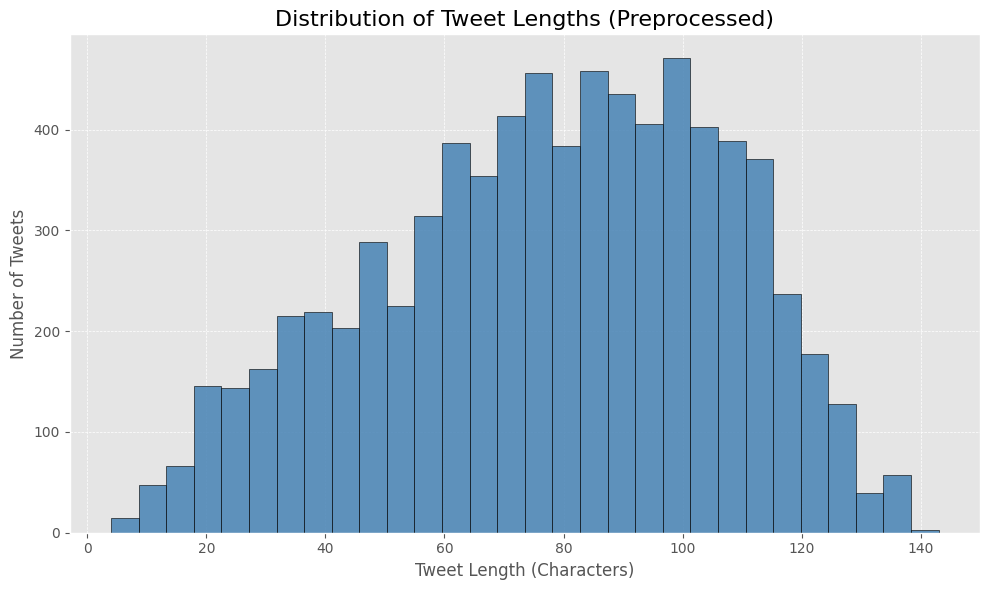

In [9]:
plt.style.use('ggplot')

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_train['length'], bins=30, color='steelblue', edgecolor='black', alpha=0.85)

# Add labels and title with enhanced formatting
plt.title('Distribution of Tweet Lengths (Preprocessed)', fontsize=16)
plt.xlabel('Tweet Length (Characters)', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

#### Distribution of Disaster vs Non-disaster Tweets
A pie chart to visualize the proportion of disaster-related and non-disaster tweets in the training dataset.

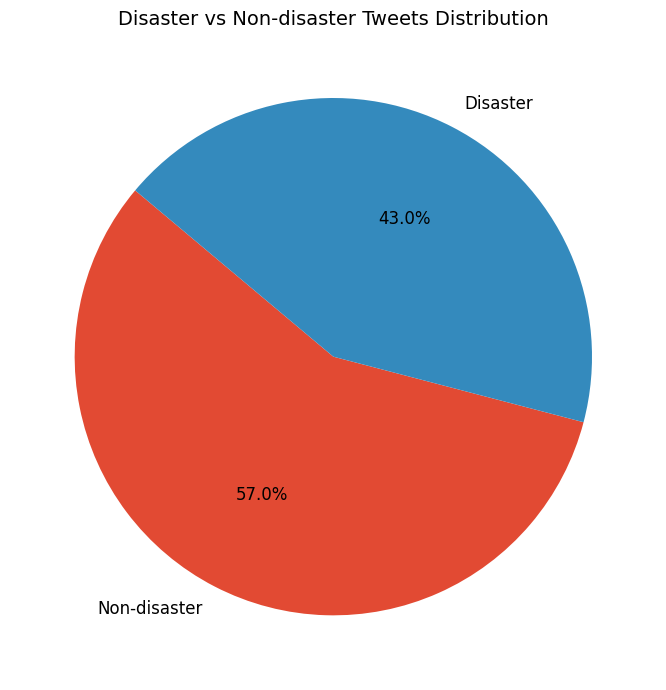

In [10]:
plt.figure(figsize=(7, 7))
df_train['target'].value_counts().plot(
    kind='pie',
    labels=['Non-disaster', 'Disaster'],
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)

plt.title('Disaster vs Non-disaster Tweets Distribution', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Average Tweet Length: Disaster vs Non-disaster
Comparing the average length of tweets between disaster-related and non-disaster-related content.

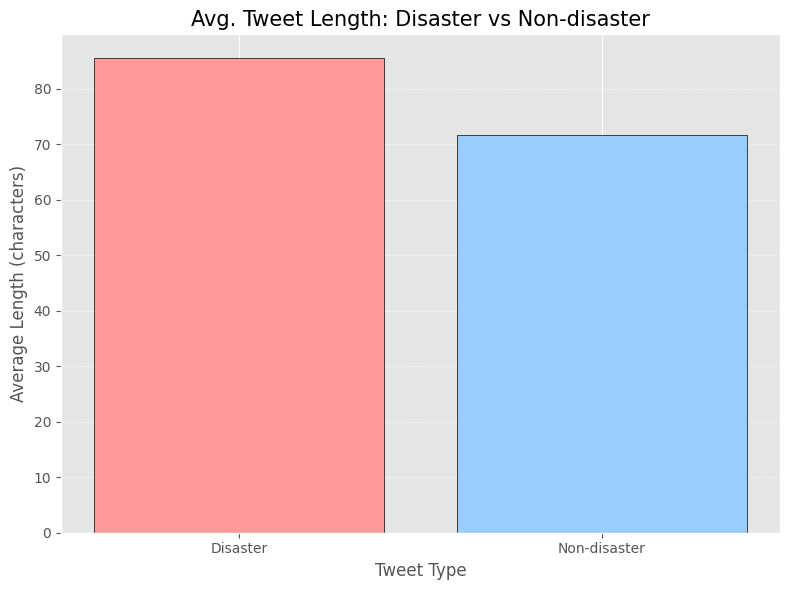

In [11]:
avg_len_disaster = df_train[df_train['target'] == 1]['length'].mean()
avg_len_non_disaster = df_train[df_train['target'] == 0]['length'].mean()

plt.figure(figsize=(8, 6))
plt.bar(
    ['Disaster', 'Non-disaster'],
    [avg_len_disaster, avg_len_non_disaster],
    color=['#ff9999', '#99ccff'],
    edgecolor='black'
)

plt.title('Avg. Tweet Length: Disaster vs Non-disaster', fontsize=15)
plt.xlabel('Tweet Type', fontsize=12)
plt.ylabel('Average Length (characters)', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### Data Preparation

We have already preprocessed the data by removing stop words and apply stemmer. We now split it into training and validation sets (80/20 split) for model training and evaluation.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train["text"], df_train["target"], test_size=0.2, random_state=42)

X_test = df_test["text"]

Since we are going to use DistilBERT, we don't need to further tokenize or vectorize the text. 

## Model Building

### Model Configuration

We define basic training hyperparameters for batch size and number of epochs, and configure TensorFlow's data pipeline optimization.



In [13]:
BATCH_SIZE = 64
EPOCHS = 3

### Model Overview: DistilBERT

We use **DistilBERT**, a smaller and faster version of BERT that retains most of its performance while reducing training time and model size.

**Key benefits of DistilBERT:**

* Pretrained transformer with contextual understanding
* Fewer parameters than BERT (≈40% smaller)
* Faster inference and training time
* Supports fine-tuning for classification tasks



### Architecture Summary

DistilBERT is built on the transformer architecture:

* Self-attention mechanism to capture context across words
* Pretrained on large text corpora
* Learns via *knowledge distillation* from the larger BERT model
* Omits some components of BERT (like token-type embeddings) for efficiency


### Model & Preprocessor Setup

We load a pretrained DistilBERT model and attach its built-in preprocessor to automatically handle tokenization and formatting.




In [14]:
preset = "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="preprocessor_for_tweets"
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
)

I0000 00:00:1747537054.414435      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


###  Model Compilation

We compile the classifier using a low learning rate and sparse categorical cross-entropy, suitable for multi-class (or binary) classification with logits.

In [15]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

# To view the model layers and parameters:
classifier.summary()

Preprocessor: "preprocessor_for_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

###  Model Training

Now we train the model on the processed tweet data.


In [16]:
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/3


I0000 00:00:1747537090.252368      90 service.cc:148] XLA service 0x7df4bc005090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747537090.252891      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747537092.646132      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747537109.032231      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 112s 695ms/step - accuracy: 0.6725 - loss: 0.6154 - val_accuracy: 0.8162 - val_loss: 0.4459
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 490ms/step - accuracy: 0.8092 - loss: 0.4404 - val_accuracy: 0.8240 - val_loss: 0.4253
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 490ms/step - accuracy: 0.8359 - loss: 0.3898 - val_accuracy: 0.8247 - val_loss: 0.4236


In [17]:
### [If needed] Uncomment the code to save and load model

# classifier.save("my_model_folder.keras")

# model_temp = keras_nlp.models.DistilBertClassifier.from_preset(preset,preprocessor = preprocessor,num_classes=2)
# model_temp.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=tf.keras.optimizers.Adam(1e-5),
#     metrics= ["accuracy"]  
# )
# model_temp.load_weights("my_model_folder.keras")

# y_pred_train_temp = model_temp.predict(X_train)
# displayConfusionMatrix(y_train, y_pred_train_temp, "Training")

### Evaluation
To assess model performance, we visualize the confusion matrix and compute the F1 score for both the training and validation datasets.
#### Define Confusion Matrix Visualization

In [18]:
def display_confusion_matrix(y_true, y_pred, dataset_name):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap="Blues"
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + 0.5 * (fp + fn))

    disp.ax_.set_title(
        f"Confusion Matrix on {dataset_name} Dataset -- F1 Score: {f1_score:.2f}"
    )

191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step


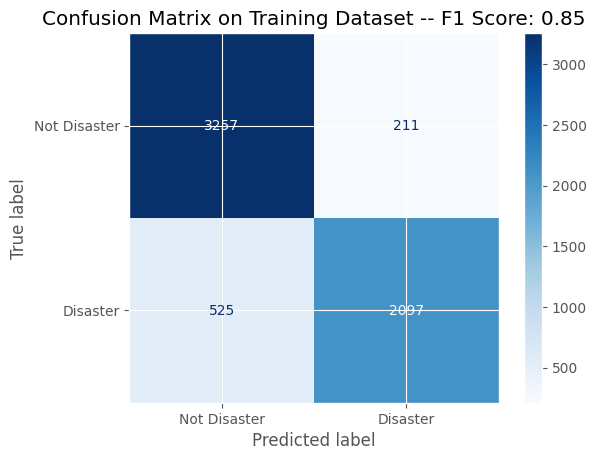

In [19]:
y_pred_train = classifier.predict(X_train)

display_confusion_matrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step


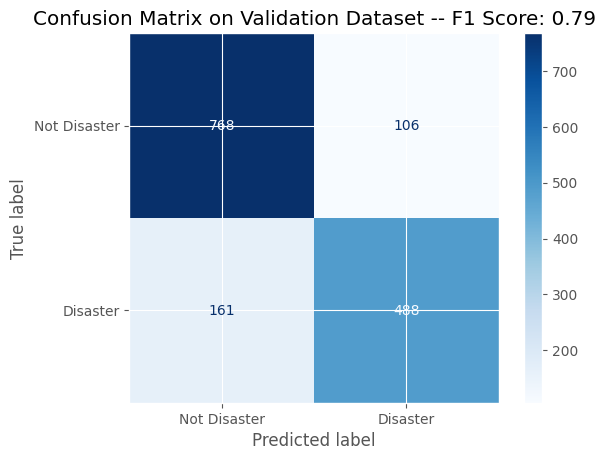

In [20]:
y_pred_val = classifier.predict(X_val)

display_confusion_matrix(y_val, y_pred_val, "Validation")

So the confusion matrix shows that we have a very high F1 score and true positive/negative rate. 

### Evaluation Metrics: Accuracy, Precision, Recall, F1 Score
We evaluate the model on both training and validation sets using standard classification metrics.



#### Metrics Calculation

In [21]:
y_pred_train_labels = np.argmax(classifier.predict(X_train), axis=1)
accuracy_train = accuracy_score(y_train, y_pred_train_labels)
precision_train = precision_score(y_train, y_pred_train_labels)
recall_train = recall_score(y_train, y_pred_train_labels)
f1_train = f1_score(y_train, y_pred_train_labels)

print(f"Training Accuracy: {accuracy_train:.2f}")
print(f"Training Precision: {precision_train:.2f}")
print(f"Training Recall: {recall_train:.2f}")
print(f"Training F1 Score: {f1_train:.2f}")

191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step
Training Accuracy: 0.88
Training Precision: 0.91
Training Recall: 0.80
Training F1 Score: 0.85


In [22]:
y_pred_val_labels = np.argmax(classifier.predict(X_val), axis=1)
accuracy_val = accuracy_score(y_val, y_pred_val_labels)
precision_val = precision_score(y_val, y_pred_val_labels)
recall_val = recall_score(y_val, y_pred_val_labels)
f1_val = f1_score(y_val, y_pred_val_labels)

print(f"Validation Accuracy: {accuracy_val:.2f}")
print(f"Validation Precision: {precision_val:.2f}")
print(f"Validation Recall: {recall_val:.2f}")
print(f"Validation F1 Score: {f1_val:.2f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step
Validation Accuracy: 0.82
Validation Precision: 0.82
Validation Recall: 0.75
Validation F1 Score: 0.79


#### Metrics Comparison Plot

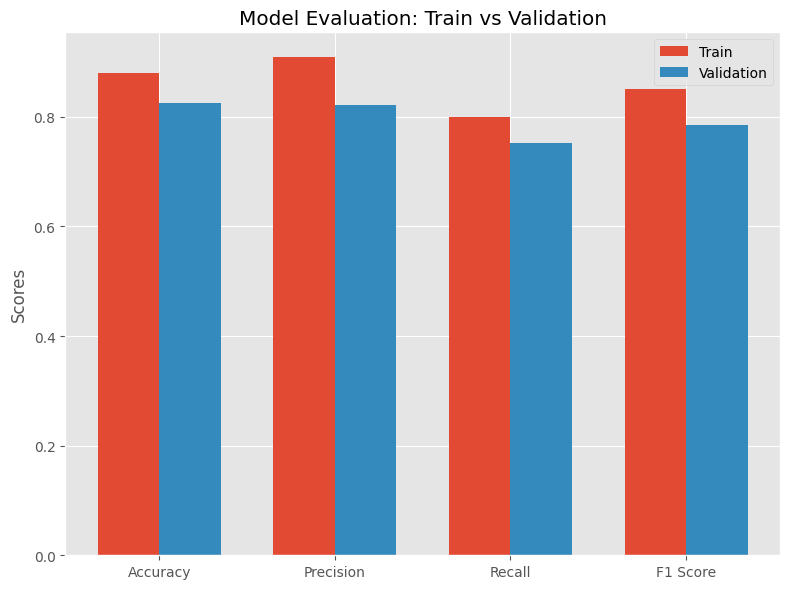

In [23]:

metrics_train = [accuracy_train, precision_train, recall_train, f1_train]
metrics_val = [accuracy_val, precision_val, recall_val, f1_val]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, metrics_train, width, label='Train')
rects2 = ax.bar(x + width/2, metrics_val, width, label='Validation')

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation: Train vs Validation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

From the plot, the F1 score for training is 0.85 and is close to 0.79 for validation. 

## Prediction Output
After training and validating the model, we generate predictions on the test set and export the results for submission. 
The submission got 0.80968 score.

In [24]:
sample_submission = pd.read_csv(f"{root_dir}sample_submission.csv")
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
sample_submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


### Conclusion

In this project, we addressed a real-world natural language processing (NLP) task: classifying tweets based on whether they report actual disasters.

#### Key Steps:

* **Preprocessing**: We cleaned the tweet data through lowercasing, token processing, and optional stemming.
* **Modeling**: We leveraged a pretrained `DistilBERT` model via `keras_nlp`, which understands contextual language using the transformer architecture.
* **Evaluation**: We assessed performance using classification metrics and confusion matrices for both training and validation datasets.
* **Prediction & Submission**: We predicted on unseen test data and prepared a final submission file.

#### Final Notes:

This workflow highlights how transfer learning with transformer-based models like DistilBERT can streamline complex NLP tasks with minimal manual feature engineering. The project is extensible for further experimentation, such as model ensembling, adversarial validation, or domain-specific fine-tuning.
